<a href="https://colab.research.google.com/github/flying-bear/modeling_schizo/blob/master/Apply_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re

from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm

In [0]:
tqdm.pandas()

In [0]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [0]:
def random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])

In [0]:
def cos_sim(v1, v2):
    return np.inner(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [0]:
with open('/content/drive/My Drive/studies/HSE/science/Schizophrenia_private/Schizo_НЦПЗ/Транскрипты/applied.pickle', 'rb') as f:
  data = pickle.load(f)

In [0]:
tests = ['child', 'chair', 'gift', 'suit']

In [129]:
data.columns

Index(['child', 'gift', 'suit', 'chair', 'child_edus', 'child_utt_num',
       'child_edu_num', 'chair_edus', 'chair_utt_num', 'chair_edu_num',
       'gift_edus', 'gift_utt_num', 'gift_edu_num', 'suit_edus',
       'suit_utt_num', 'suit_edu_num', 'child_lemmas', 'chair_lemmas',
       'gift_lemmas', 'suit_lemmas', 'child_mean_edu_len', 'child_min_edu_len',
       'child_max_edu_len', 'child_word_count', 'chair_mean_edu_len',
       'chair_min_edu_len', 'chair_max_edu_len', 'chair_word_count',
       'gift_mean_edu_len', 'gift_min_edu_len', 'gift_max_edu_len',
       'gift_word_count', 'suit_mean_edu_len', 'suit_min_edu_len',
       'suit_max_edu_len', 'suit_word_count', 'child_lemmas_w2v',
       'chair_lemmas_w2v', 'gift_lemmas_w2v', 'suit_lemmas_w2v', 'child_sif',
       'chair_sif', 'gift_sif', 'child_elmo', 'chair_elmo', 'gift_elmo',
       'suit_elmo', 'child_bert', 'chair_bert', 'gift_bert', 'suit_bert',
       'suit_sif'],
      dtype='object')

In [0]:
data = data[['child_sif', 'chair_sif', 'gift_sif', 'suit_sif', 
             'child_elmo', 'chair_elmo', 'gift_elmo', 'suit_elmo', 
             'child_bert', 'chair_bert', 'gift_bert', 'suit_bert']]

In [131]:
data.tail(2)

,child_sif,chair_sif,gift_sif,suit_sif,child_elmo,chair_elmo,gift_elmo,suit_elmo,child_bert,chair_bert,gift_bert,suit_bert
ID,,,,,,,,,,,,
S20,"[[-0.1309083046597268, 1.5931118150382497, -0....","[[-1.353279945076223, 0.6755457928830055, -0.1...","[[-0.5361064549577625, 0.4616249325175217, -0....","[[-0.2715050042549043, 0.9398792190364805, 0.5...","[[-0.2780114, -0.57365817, 0.22401376, -2.2336...","[[-0.5764583, -0.21059678, 0.061395194, -0.256...","[[-0.06162157, -0.3700385, 0.7188135, 0.072670...","[[-0.6554408, -1.5173392, 0.5360127, -0.062073...","[[0.65086037, 0.30297586, 0.8016355, 0.4996233...","[[1.0759436, -0.049940437, 0.31772918, 0.30023...","[[1.1465244, -0.18004239, 0.045954917, 0.18331...","[[0.8262927, 0.40695453, 0.7690175, 0.12168455..."
S21,"[[-0.46076551556873424, 1.6885666351354667, -0...",NaN,NaN,"[[1.6140930878184254, 0.3511087962990732, -1.2...","[[-0.7621543, -0.8216656, -0.3929461, -1.32644...",NaN,NaN,"[[-0.45703903, -0.48333216, 1.1214621, 0.24196...","[[0.6989477, 0.4510869, 0.757079, 0.75145894, ...",NaN,NaN,"[[0.38941172, 0.44076353, 0.22852577, 0.519196..."


In [0]:
data['binary_diagnosis'] = [1 if 'H' in i else 0 for i in data.index]

## Plotting and averaging


In [0]:
def average_text_vector_dict(array_of_arrays):
    """
    gets minimum, median, and maximun for each list in input

    :param array_of_arrays: lsit of lists of int or float

    :return: dict of lists,
        keys: {'min','med','max'}
        values: float or int, min, median, maximum of each list in input
    """
    max_len = max([len(x) for x in array_of_arrays])
    result_dict = {'min':[],'med':[],'max':[]}
    for i in range(max_len):
        current = []
        for arr in array_of_arrays:
            try:
                current.append(arr[i])
            except IndexError:
                continue
        if current is not None:
            result_dict['min'].append(min(current))
            result_dict['max'].append(max(current))
            result_dict['med'].append(np.median(current))
        else:
            print(i, max_len)
    return result_dict

In [0]:
def plot_average(result_dict, labels={'med':'median', 'min':'minimum', 'max':'maximum'},
                 colors={'med':'r', 'min':'#fd5c74', 'max':'#fd5c74'}, title='averaged metric'):
  """
  plots average_dict result

  :param result_dict: dict of lists,
        keys: {'min','med','max'}
        values: float or int, min, median, maximum of each list in input
  :param labels: dict of lables
        keys: {'min','med','max'}
        values: str, full label
  :param colors: dict of colors
        keys: {'min','med','max'}
        values: str, colors
  """
  length = len(result_dict['med'])
  plt.plot(np.arange(length)+1, result_dict['med'], color=colors['med'], label=labels['med'], linestyle='-')
  plt.plot(np.arange(length)+1, result_dict['min'], color=colors['min'], label=labels['min'], linestyle=':')
  plt.plot(np.arange(length)+1, result_dict['max'], color=colors['max'], label=labels['max'], linestyle=':')
  plt.title(label=title)
  plt.legend()
  plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})

# Semi-local coherence
#### cumulative semi-local coherence
a plot: <br>
x axis: distance between the clauses (measured in clauses or words) <br>
y axis: cosine distance between an averaged vector of the first <i>n</i> clauses and the current clause

In [0]:
def get_cumulative_semi_loc_coh_array(clause_vectors):
  """
  calculates cummulative coherence
  :param clause_vectors: list of np.arrays (vectors) or a np.array of shape (sent_len, emb_size)

  :return: list of float of len sent_len, cummulative coherence of each clasue
  """
  cumulative_semi_loc_coh_array = []
  for i in range(len(clause_vectors)):
      if i:
          cumulative_semi_loc_coh_array.append(
              cos_sim(np.mean(clause_vectors[:i], axis=0), clause_vectors[i]))
  return cumulative_semi_loc_coh_array

In [138]:
get_cumulative_semi_loc_coh_array(data['child_elmo']['S01'])

[0.44718066,
 0.62662923,
 0.46851102,
 0.5704978,
 0.52095497,
 0.6464621,
 0.667204,
 0.6685148,
 0.73535234,
 0.502023,
 0.6746772]

In [0]:
for col in tests:
  data[f'{col}_cum_semi_loc_coh_sif'] = data[f'{col}_sif' ][~pd.isnull(data[f'{col}_sif' ])].apply(get_cumulative_semi_loc_coh_array)
  data[f'{col}_mean_semi_loc_coh_sif'] = data[f'{col}_cum_semi_loc_coh_sif'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_sif'])].apply(np.mean)
  data[f'{col}_max_semi_loc_coh_sif'] = data[f'{col}_cum_semi_loc_coh_sif'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_sif'])].apply(max)

In [0]:
for col in tests:
  data[f'{col}_cum_semi_loc_coh_bert'] = data[f'{col}_bert' ][~pd.isnull(data[f'{col}_bert' ])].apply(get_cumulative_semi_loc_coh_array)
  data[f'{col}_mean_semi_loc_coh_bert'] = data[f'{col}_cum_semi_loc_coh_bert'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_bert'])].apply(np.mean)
  data[f'{col}_max_semi_loc_coh_bert'] = data[f'{col}_cum_semi_loc_coh_bert'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_bert'])].apply(max)

In [0]:
for col in tests:
  data[f'{col}_cum_semi_loc_coh_elmo'] = data[f'{col}_elmo' ][~pd.isnull(data[f'{col}_elmo' ])].apply(get_cumulative_semi_loc_coh_array)
  data[f'{col}_mean_semi_loc_coh_elmo'] = data[f'{col}_cum_semi_loc_coh_elmo'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_elmo'])].apply(np.mean)
  data[f'{col}_max_semi_loc_coh_elmo'] = data[f'{col}_cum_semi_loc_coh_elmo'][~pd.isnull(data[f'{col}_cum_semi_loc_coh_elmo'])].apply(max)

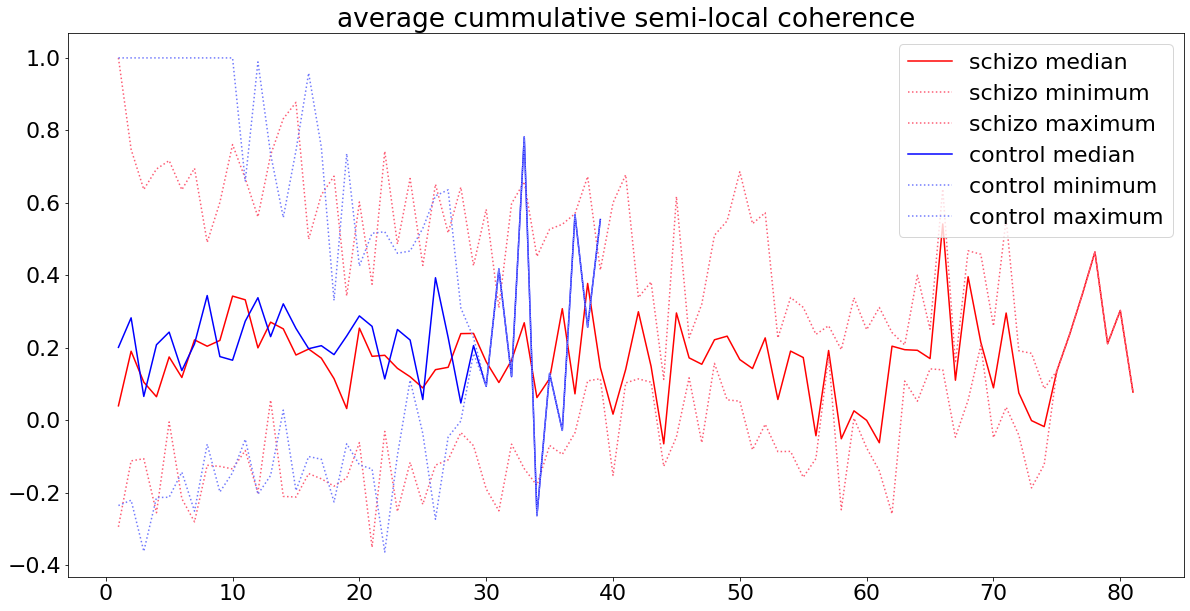

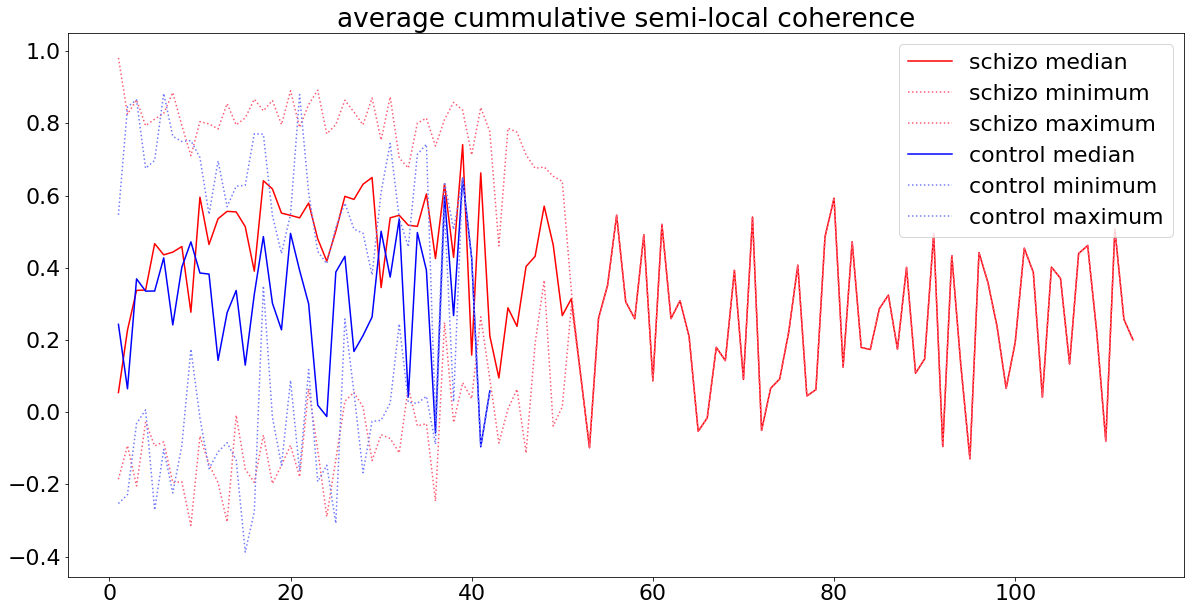

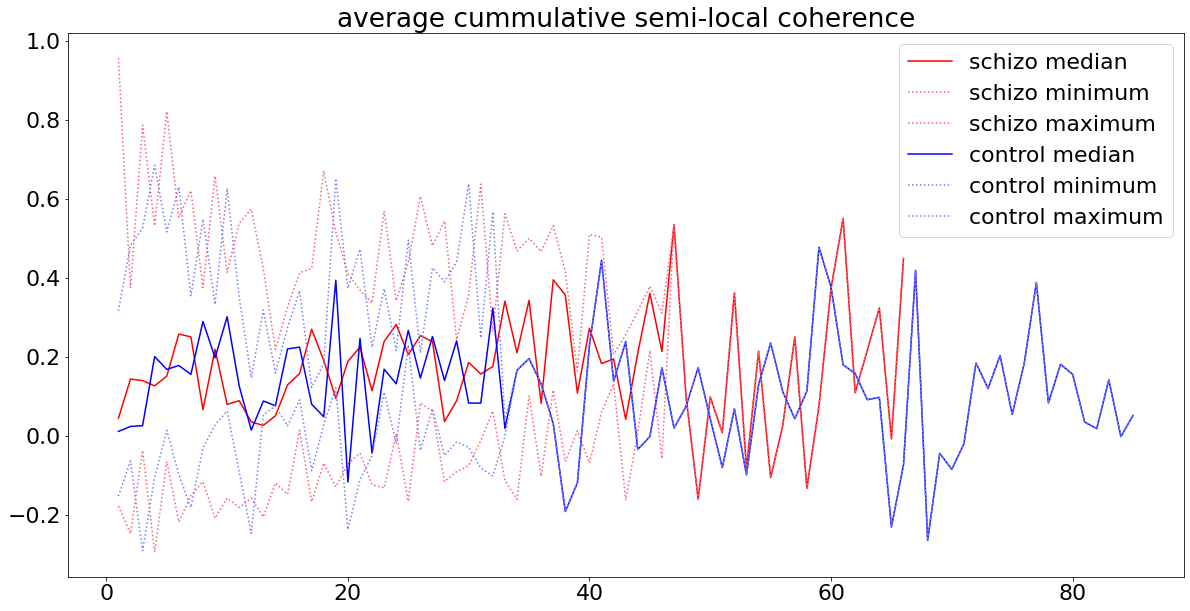

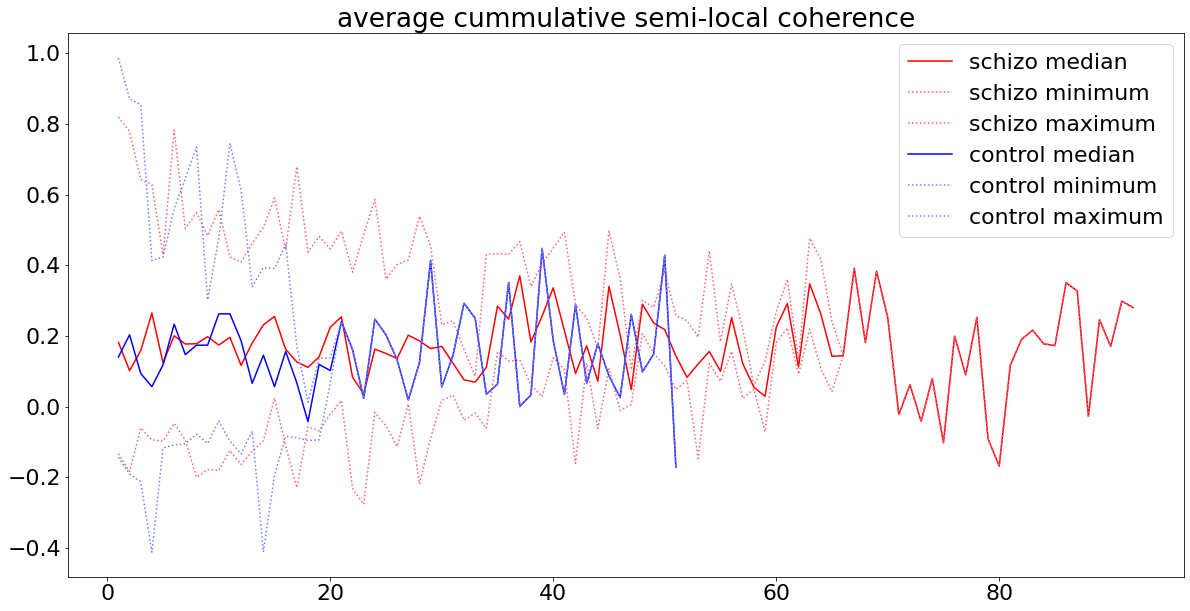

In [144]:
for col in tests:
  min_c, med_c, max_c, min_s, med_s, max_s = data[~pd.isnull(data[f'{col}_cum_semi_loc_coh_sif'])].groupby('binary_diagnosis')[f'{col}_cum_semi_loc_coh_sif' ].apply(average_text_vector_dict)
  dict_control =  {'min': min_c, 'max': max_c, 'med': med_c}
  dict_schizo = {'min': min_s, 'max': max_s, 'med':med_s}
  plot_average(dict_schizo, labels={'med':'schizo median', 'min':'schizo minimum', 'max':'schizo maximum'})
  plot_average(dict_control, labels={'med':'control median', 'min':'control minimum', 'max':'control maximum'}, 
             colors={'med':'b', 'min':'#717afd', 'max':'#717afd'}, title='average cummulative semi-local coherence')
  plt.show()